In [1]:
import torch
import ST
from sklearn.model_selection import train_test_split
import torchmetrics

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device


device(type='cuda', index=0)

## Structures for segmentation

In [2]:
class Unet (torch.nn.Module):
    def __init__(
        self,
    ):
        super().__init__()

        self.d0 = ST.Conv(
            input_channels = 3,
            output_channels = 32,
            kernel_size = 1,
            padding = 0,
        )

        self.d1 = ST.Conv(
            input_channels = 32,
            output_channels = 64,
            kernel_size = 5,
            padding = 2,
            stride = 2,
        )

        self.d2 = ST.Conv(
            input_channels = 64,
            output_channels = 128,
            kernel_size = 5,
            padding = 2,
            stride = 2,
        )

        self.d3 = ST.Conv(
            input_channels = 128,
            output_channels = 256,
            kernel_size = 5,
            padding = 2,
            stride = 2,
        )

        self.base = ST.Conv(
            input_channels = 256,
            output_channels = 256,
            kernel_size = 5,
            padding = 2,
            stride = 2,
        )

        self.u1 = ST.Up_Conv(
            input_channels = 256,
            output_channels = 128,
            kernel_size = 3,
            padding = 1,
            scale_factor = 2.,
        )

        self.u2 = ST.Up_Conv(
            input_channels = 384,
            output_channels = 128,
            kernel_size = 3,
            padding = 1,
            scale_factor = 2.,
        )

        self.u3 = ST.Up_Conv(
            input_channels = 256,
            output_channels = 128,
            kernel_size = (4, 3),
            padding = 1,
            scale_factor = 2.,
        )

        self.u4 = ST.Up_Conv(
            input_channels = 192,
            output_channels = 32,
            kernel_size = 3,
            padding = 1,
            scale_factor = 2.,
        )

        self.final_activation = torch.nn.Sigmoid()

        self.final_conv = torch.nn.Conv2d(
            in_channels = 64,
            out_channels = 1,
            kernel_size = 1,
            padding = 0,
        )

    def forward(self, tensor):
        d0 = self.d0(tensor)
        d1 = self.d1(d0)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        
        base = self.base(d3)
        
        u1 = torch.cat((
            self.u1(base),
            d3
        ), dim = 1)

        u2 = torch.cat((
            self.u2(u1),
            d2,
        ), dim = 1)

        u3 = torch.cat((
            self.u3(u2),
            d1,
        ), dim = 1)

        u4 = torch.cat((
            self.u4(u3),
            d0,
        ), dim = 1)

        final_conv = self.final_activation(self.final_conv(u4))
    
        return final_conv

In [3]:
def neg_log_iou (tensor1, tensor2):
    iou_loss = torchmetrics.classification.BinaryJaccardIndex().to(device)
    return (iou_loss(tensor1, tensor2).log()) * -1

In [4]:
model = Unet()
model(torch.zeros((1, 3, 270, 480))).shape

torch.Size([1, 1, 270, 480])

In [5]:
ST.torchsummary.summary(Unet(), torch.zeros((1, 3, 270, 480)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv: 1-1                              [-1, 32, 270, 480]        --
|    └─Sequential: 2-1                   [-1, 32, 270, 480]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 270, 480]        128
|    |    └─BatchNorm2d: 3-2             [-1, 32, 270, 480]        64
|    |    └─ReLU: 3-3                    [-1, 32, 270, 480]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ReLU: 3-4                    [-1, 32, 270, 480]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ReLU: 3-5                    [-1, 32, 270, 480]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─Re

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv: 1-1                              [-1, 32, 270, 480]        --
|    └─Sequential: 2-1                   [-1, 32, 270, 480]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 270, 480]        128
|    |    └─BatchNorm2d: 3-2             [-1, 32, 270, 480]        64
|    |    └─ReLU: 3-3                    [-1, 32, 270, 480]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ReLU: 3-4                    [-1, 32, 270, 480]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─ReLU: 3-5                    [-1, 32, 270, 480]        --
├─Conv: 1                                []                        --
|    └─Sequential: 2                     []                        --
|    |    └─Re

## Getting dataset

In [6]:
train_images = torch.load("Saved Tensors/Augmented images.pth")
train_answers = torch.load("Saved Tensors/Segmentation answers.pth").resize(202, 1, 270, 480)
train_images.shape

C:\Users\vital\anaconda3\Lib\site-packages\torch\_tensor.py:893: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


torch.Size([1010, 3, 270, 480])

In [7]:
train_X = train_images[:950].to(device)
val_X = train_images[950:].to(device)
train_y = train_answers[:190].to(device = device, dtype = torch.float32)
val_y = train_answers[190:].to(device, dtype = torch.float32)

## Teaching model

In [8]:
model = Unet().to(device)

st_model = ST.Model_Using(model = model,
                          device = device)

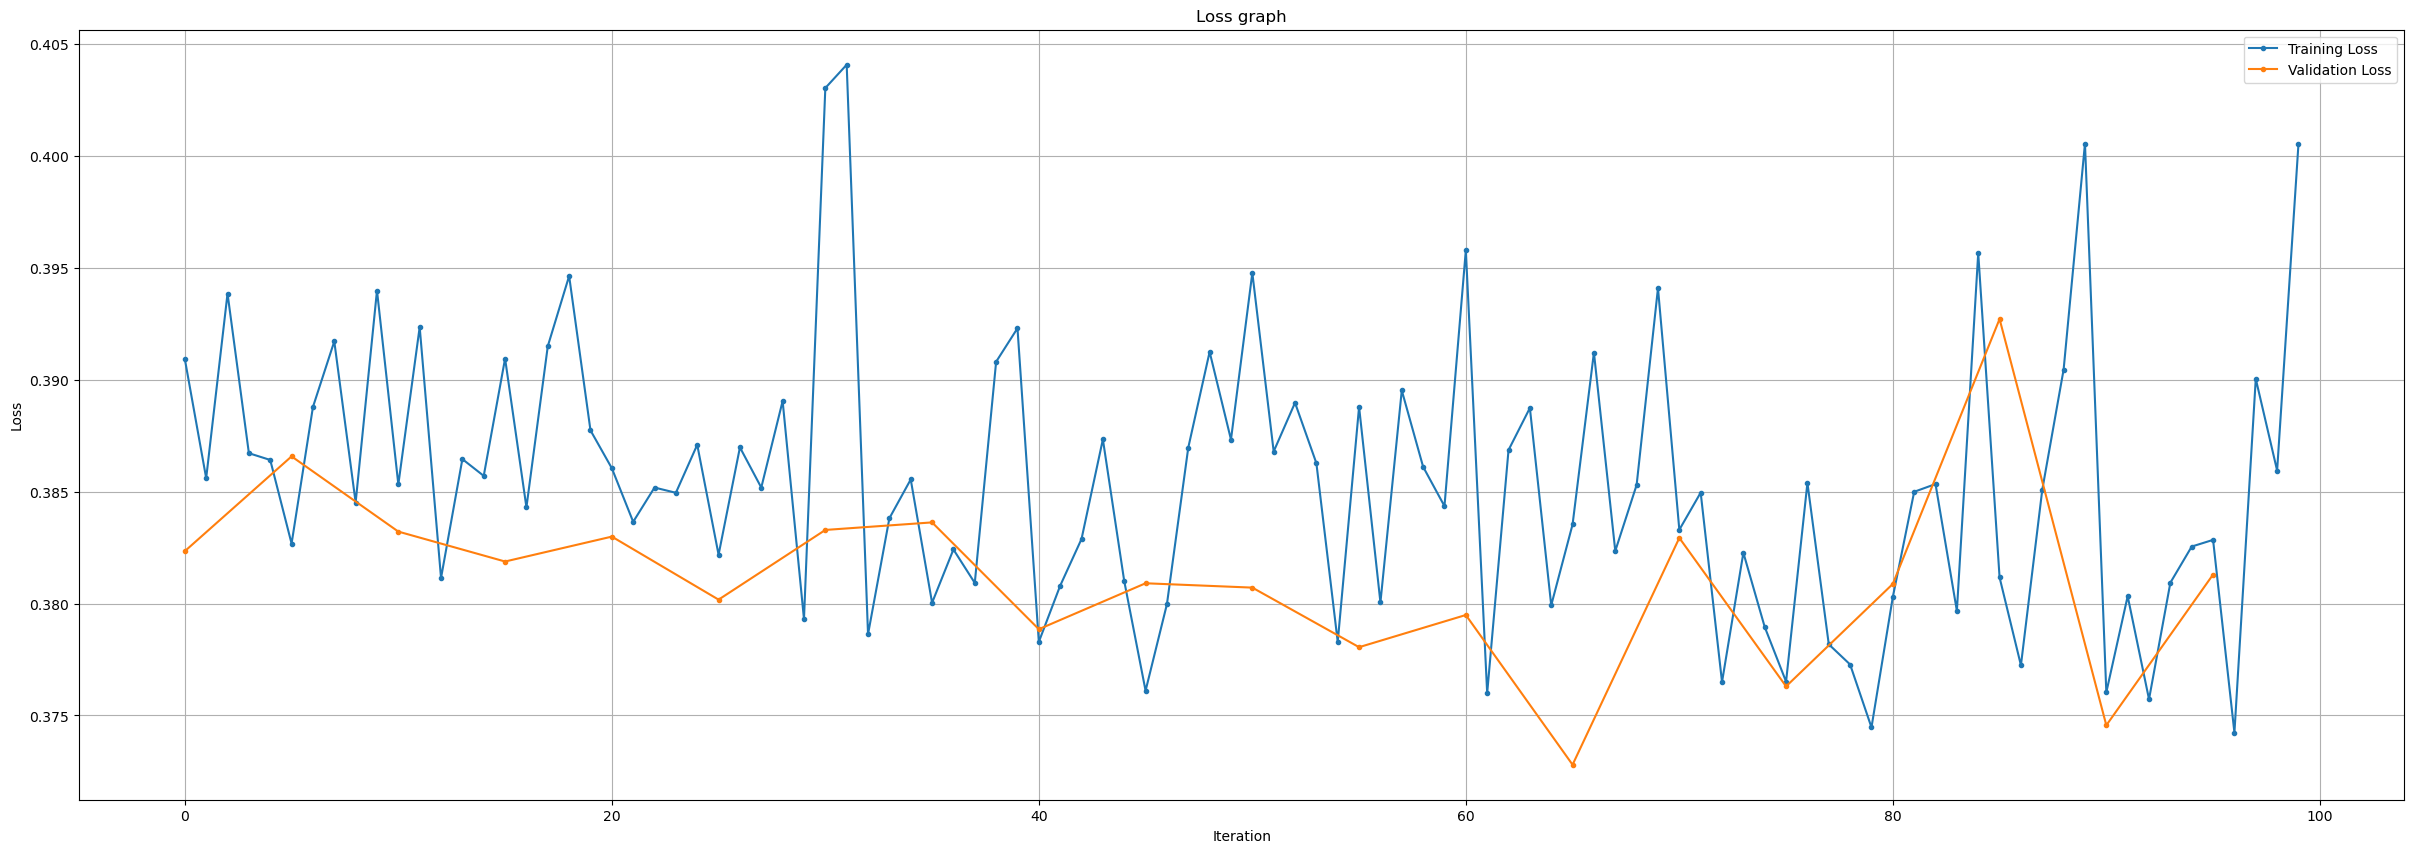

Teaching has been complete successfully


In [14]:
st_model.Train(
    train_X = train_X,
    train_y = train_y,
    val_X = val_X,
    val_y = val_y,
    num_of_epochs = 100,
    learning_rate = 1e-4,
    batch_size = 10,
    loss_func = torch.nn.BCELoss(), 
    use_reg = False,
    reg_level = 2,
    optimizer = 1,
    is_sched_use = True,
    scheduler_freq = 50,
    scheduler_gamma = 0.5,
    val_every = 5,
    show_every = 5,
)

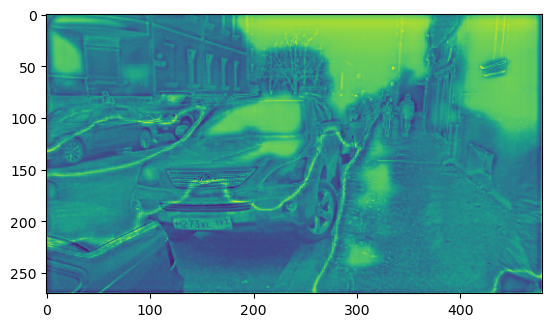

In [15]:
pred = st_model.Use(train_X[123].reshape((1, 3, 270, 480)))
ST.imshow(pred.resize(1, 270, 480))

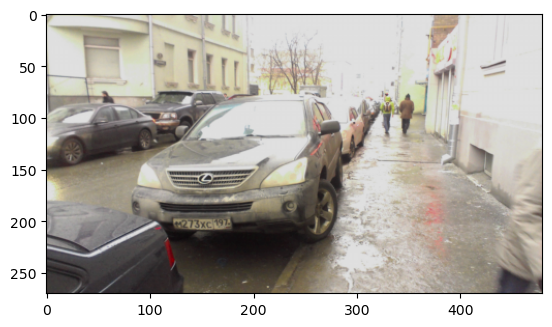

In [16]:
ST.imshow(train_X[123])

In [12]:
help(torch.Tensor)

Help on class Tensor in module torch:

class Tensor(torch._C.TensorBase)
 |  Method resolution order:
 |      Tensor
 |      torch._C.TensorBase
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __abs__ = abs(...)
 |  
 |  __array__(self, dtype=None)
 |  
 |  __array_wrap__(self, array)
 |      # Wrap Numpy array again in a suitable tensor when done, to support e.g.
 |      # `numpy.sin(tensor) -> tensor` or `numpy.greater(tensor, 0) -> ByteTensor`
 |  
 |  __contains__(self, element)
 |      Check if `element` is present in tensor
 |      
 |      Args:
 |          element (Tensor or scalar): element to be checked
 |              for presence in current tensor"
 |  
 |  __deepcopy__(self, memo)
 |  
 |  __dir__(self)
 |      Default dir() implementation.
 |  
 |  __dlpack__(self, stream=None)
 |      Creates a DLpack `capsule https://data-apis.org/array-api/latest/design_topics/data_interchange.html#data-interchange`_
 |      of the current tensor to be exported to other

In [13]:
loss = torchmetrics.classification.BinaryJaccardIndex()

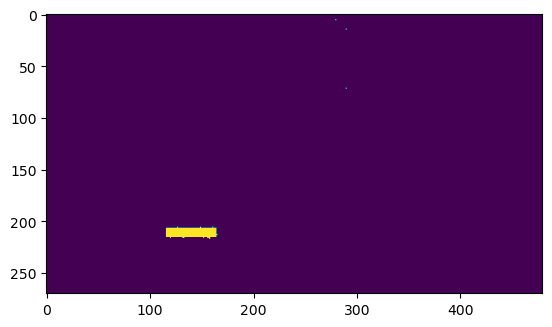

In [17]:
ST.imshow(train_y[123])